In [1]:
import xarray as xr 
import src as xc 
import matplotlib.pyplot as plt 
import pandas as pd 

firstn = 1

global_nmme_djf = xr.open_dataset('casestudy_data/GLOBAL_L1_DJF.nc').prec
#global_nmme_mam = xr.open_dataset('casestudy_data/GLOBAL_L1_MAM.nc').prec
#global_nmme_jja = xr.open_dataset('casestudy_data/GLOBAL_L1_JJA.nc').prec
#global_nmme_son = xr.open_dataset('casestudy_data/GLOBAL_L1_SON.nc').prec

global_cpc_djf = xr.open_dataset('casestudy_data/GLOBAL_CPC_DJF.nc').prate.expand_dims({'M':[0]})
#global_cpc_mam = xr.open_dataset('casestudy_data/GLOBAL_CPC_MAM.nc').prate.expand_dims({'M':[0]})
#global_cpc_jja = xr.open_dataset('casestudy_data/GLOBAL_CPC_JJA.nc').prate.expand_dims({'M':[0]})
#global_cpc_son = xr.open_dataset('casestudy_data/GLOBAL_CPC_SON.nc').prate.expand_dims({'M':[0]})

xs = [global_nmme_djf ]#, global_nmme_mam, global_nmme_jja, global_nmme_son]
ys = [global_cpc_djf ]# , global_cpc_mam, global_cpc_jja, global_cpc_son]

ohcs = []
for j in range(firstn):
    ohc = xc.RankedTerciles()
    ohc.fit(ys[j])
    y_ohc = ohc.transform(ys[j])
    ohcs.append(y_ohc)

In [2]:
poelms = []
for j in range(firstn):
    poelm_xval = []
    i = 1
    for x_train, y_train, x_test, y_test in xc.CrossValidator(xs[j].load(), ys[j].load(), window=1):
        start = pd.Timestamp.now()
        ohc = xc.RankedTerciles()
        ohc.fit(y_train)
        ohc_y_train = ohc.transform(y_train)

        poelm = xc.cPOELM(ND=10, hidden_layer_size=5, lat_chunks=1, lon_chunks=1, activation='relu', verbose=True)
        poelm.fit(x_train, ohc_y_train)
        poelm_preds = poelm.predict(x_test)
        poelm_xval.append(poelm_preds.isel(S=0))
        print('Fiting Window {}/37 - {}'.format(i, pd.Timestamp.now() - start), end='\r')
        i+= 1
    poelm = xr.concat(poelm_xval, 'S').mean('ND')
    print()
    poelms.append(poelm)
    


[########################################] | 100% Completed |  1min 21.7s
[########################################] | 100% Completed |  1min 22.3s
[########################################] | 100% Completed |  1min 19.2s
[########################################] | 100% Completed |  1min 22.3s
[########################################] | 100% Completed |  1min 20.6s
[########################################] | 100% Completed |  1min 24.2s
[########################################] | 100% Completed |  1min 19.0s
[########################################] | 100% Completed |  1min 21.1s
[########################################] | 100% Completed |  1min 21.2s
[########################################] | 100% Completed |  1min 20.6s
[########################################] | 100% Completed |  1min 20.9s
[########################################] | 100% Completed |  1min 20.5s
[########################################] | 100% Completed |  1min 19.2s
[#####################################

In [3]:
grocs, rpsss = [], []
for j in range(firstn):
    groc = xc.GeneralizedROC(poelms[j], ohcs[j])
    poelm_rps = xc.RankProbabilityScore(poelms[j], ohcs[j])
    climatological_odds = xr.ones_like(poelms[j]) * 0.33 
    climo_rps = xc.RankProbabilityScore(climatological_odds, ohcs[j])
    rpss = 1 - ( poelm_rps / climo_rps)
    grocs.append(groc)
    rpsss.append(rpss)

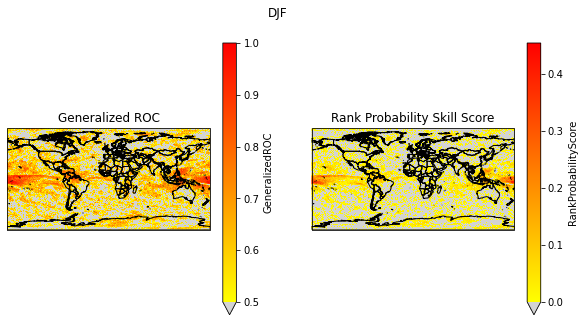

In [5]:
import cartopy.crs as ccrs 
import matplotlib.pyplot as plt 
import cartopy.feature as cfeature

cmap = plt.get_cmap('autumn_r')
cmap.set_under('lightgray')

titles = [ 'DJF', 'MAM', 'JJA', 'SON']

for j in range(firstn):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), subplot_kw={'projection': ccrs.PlateCarree()})
    grocs[j].plot(ax=ax[0], vmin=0.5, vmax=1, cmap=cmap)
    states_provinces = cfeature.NaturalEarthFeature(category='cultural', name='admin_0_countries', scale='50m', facecolor='none')
    ax[0].add_feature(states_provinces)
    ax[0].set_title('Generalized ROC')

    rpsss[j].plot(ax=ax[1], vmin=0,  cmap=cmap)
    ax[1].add_feature(states_provinces)
    ax[1].set_title('Rank Probability Skill Score')
    plt.suptitle(titles[j])
    plt.show()